<a href="https://colab.research.google.com/github/czengnn/lana-del-rey-lyrics-generator/blob/main/LDR_by_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd 
import numpy as np 
import re 
import os
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import sparse_categorical_crossentropy

from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [2]:
# load songs
songs1 = pd.read_csv('/content/drive/MyDrive/data/lana_lyrics_83.csv').drop('Unnamed: 0', axis=1)
songs2 = pd.read_csv('/content/drive/MyDrive/data/lana_lyrics_15.csv').drop('Unnamed: 0', axis=1)
songs = pd.concat([songs1, songs2], axis=0)
songs.shape

(98, 2)

In [3]:
# put lyrics into 1 string
text = ''
for song in songs['lyrics']:
    text = text + song.lower()
    
# remove the text with brackets around them, such as [Verse 1]
text = re.sub(r'\[[^][]*\]', '', text)

In [4]:
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

Length of text: 161722 characters
61 unique characters


In [63]:
corpus = [line for line in text.split('\n') if line != '']
corpus[:10]

['why? ("got that?")',
 'who, me? ("louder!")',
 'why? ("got that?")',
 "feet don't fail me now",
 'take me to the finish line',
 'oh, my heart, it breaks every step that i take',
 "but i'm hoping at the gates, they'll tell me that you're mine",
 'walking through the city streets, is it by mistake or design?',
 'i feel so alone on a friday night',
 "can you make it feel like home, if i tell you you're mine?"]

In [65]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(set(corpus))
total_words = len(tokenizer.word_index) + 1
print(total_words)

2575


In [28]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [29]:
input_sequences[20:30]

[[28, 8, 158, 10, 1247, 145, 602],
 [28, 8, 158, 10, 1247, 145, 602, 17],
 [28, 8, 158, 10, 1247, 145, 602, 17, 3],
 [28, 8, 158, 10, 1247, 145, 602, 17, 3, 49],
 [27, 11],
 [27, 11, 808],
 [27, 11, 808, 55],
 [27, 11, 808, 55, 2],
 [27, 11, 808, 55, 2, 1248],
 [27, 11, 808, 55, 2, 1248, 603]]

In [31]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen = max_sequence_len, padding='pre'))

In [32]:
input_sequences[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 105,  33],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 105,  33,  17],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  81,   4],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  81,   4, 213],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 105,  33]], dtype=int32)

In [33]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]

### Building The Model

In [36]:
def sparse_cat_loss(y_true,y_pred):
  return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

vocab_size = total_words
embed_dim = 50
def create_model(vocab_size, embed_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=max_sequence_len-1))
    # Add an LSTM Layer
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    # A dropout layer for regularisation
    model.add(Dropout(0.2))
    # Add another LSTM Layer
    model.add(LSTM(100,return_sequences=False)) 
    model.add(Dense(vocab_size//2, activation='relu'))
    # In the last layer, the shape should be equal to the total number of words present in our corpus
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
    return model

model = create_model(vocab_size, embed_dim)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 50)            128750    
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 300)           241200    
_________________________________________________________________
dropout (Dropout)            (None, 17, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1287)              129987    
_________________________________________________________________
dense_1 (Dense)              (None, 2575)              3316600   
Total params: 3,976,937
Trainable params: 3,976,937
Non-trainable params: 0
______________________________________________

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(predictors, label, epochs=100, verbose=1, callbacks=[early_stopping])

# Save the weights
model.save_weights('/content/drive/MyDrive/data/models/ldr_by_word/ldr_by_word')

Epoch 1/100
865/865 [==============================] - 103s 119ms/step - loss: 6.0795 - accuracy: 0.0381
Epoch 2/100
865/865 [==============================] - 102s 118ms/step - loss: 5.4864 - accuracy: 0.0700
Epoch 3/100
865/865 [==============================] - 102s 118ms/step - loss: 5.1083 - accuracy: 0.0975
Epoch 4/100
865/865 [==============================] - 103s 119ms/step - loss: 4.8111 - accuracy: 0.1181
Epoch 5/100
865/865 [==============================] - 103s 119ms/step - loss: 4.5322 - accuracy: 0.1481
Epoch 6/100
865/865 [==============================] - 103s 119ms/step - loss: 4.2546 - accuracy: 0.1751
Epoch 7/100
865/865 [==============================] - 103s 119ms/step - loss: 3.9658 - accuracy: 0.2068
Epoch 8/100
865/865 [==============================] - 102s 118ms/step - loss: 3.6876 - accuracy: 0.2395
Epoch 9/100
865/865 [==============================] - 102s 118ms/step - loss: 3.4110 - accuracy: 0.2762
Epoch 10/100
865/865 [==============================] -

In [52]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


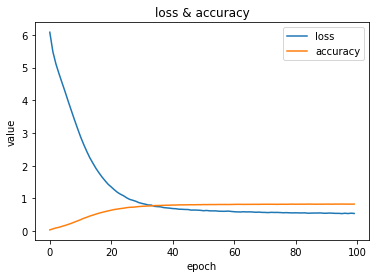

In [59]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('loss & accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()

#### Recreate the model and load saved weights

In [42]:
# Create a new model instance
model_loaded = create_model(vocab_size, embed_dim)
model_loaded.load_weights('/content/drive/MyDrive/data/models/ldr_by_word/ldr_by_word')

In [49]:
def make_lyrics(model, seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [50]:
predicted_lyrics = make_lyrics(model, 'lolita', 100)
print(predicted_lyrics)

lolita bitch lookin' at me like a magazine wearing romeo there on the city of miami fun and god i loved to sing what i need you i'd never leave you now i'm hearing arrived then we dance on that night there just swallow some wine i can change that night only mine too light as that old jukebox what your lipstick on the tour of his cocaine heart if you cigar ready on the poems we burned for sure real you got a war in my mind with you daddy hey la princesa poet resident laurel fun so light everybody


In [66]:
predicted_lyrics = make_lyrics(model_loaded, 'lolita', 100)
print(predicted_lyrics)

lolita writing guitar remember me i nevada but just that just yeah fell just but for hurt hurt hurt hurt hurt hurt hurt hurt hurt hurt hurt hurt hurt hurt hurt just yeah just yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah just just just yeah just yeah just yeah just yeah just yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah


In [67]:
predicted_lyrics = make_lyrics(model_loaded, 'baby blue', 100)
print(predicted_lyrics)

baby blue electric buy time and i'm my sends out away the mine now be remember go suit clothes sparkle blond got myself know and to the say you the rage da killing aeroplane on of deep all a catch fail in a war in soul odds away to reasons we and then to let you say back cry is love when do got put you around i have is so me famous some light know i darts jam world baby's were to reasons is stay it fiends fire two do do do do do do do do the eyes me it's
